In [83]:

import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image

## Loading Data and decimate it to 25Hz by factor 2

In [84]:
## Depends on workstation 
## day 337 in 2016 is  December 2, 2016 (Fri)


station = 'KNR01'
component = 'BH1'
year = 2016
day = 326


day = str(day)
year = str(year)
#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BH1 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
parser01_BH1 = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BH1 = st_BH1.decimate(factor=2)
st_BH1_simu = st_BH1.copy()
st_BH1_simu.simulate(seedresp={'filename': parser01_BH1, 'units': "ACC"})
st_BH1_simu_filt = st_BH1_simu.copy()
st_BH1_simu_filt = st_BH1_simu_filt.filter('bandpass',freqmin=.1, freqmax=10)


component = 'BH2'


#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BH2 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
parser01_BH2 = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BH2 = st_BH2.decimate(factor=2)
st_BH2_simu = st_BH2.copy()
st_BH2_simu.simulate(seedresp={'filename': parser01_BH2, 'units': "ACC"})
st_BH2_simu_filt = st_BH2_simu.copy()
st_BH2_simu_filt = st_BH2_simu_filt.filter('bandpass',freqmin=2, freqmax=4.9)


component = 'BHZ'


#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st_BHZ = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
parser01_BHZ = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
st_BHZ = st_BHZ.decimate(factor=2)
st_BHZ_simu = st_BHZ.copy()
st_BHZ_simu.simulate(seedresp={'filename': parser01_BHZ, 'units': "ACC"})
st_BHZ_simu_filt = st_BHZ_simu.copy()
st_BHZ_simu_filt = st_BHZ_simu_filt.filter('bandpass',freqmin=2, freqmax=4.9)



fs = int(st_BH1_simu_filt[0].stats.sampling_rate)
date = st_BHZ_simu_filt[0].stats.starttime.ctime()[4:]

/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


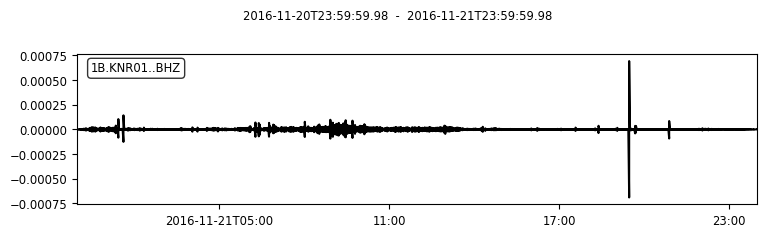

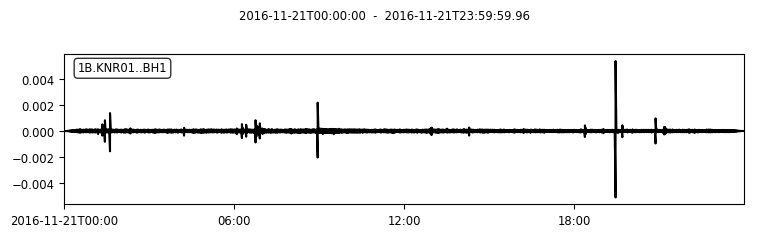

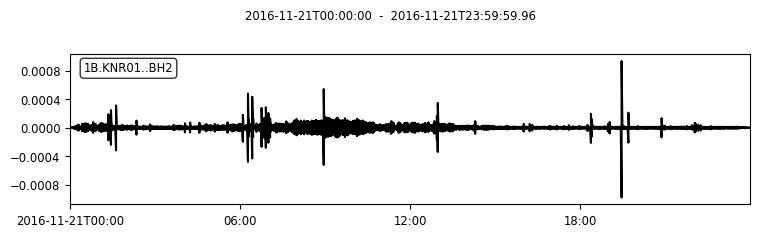

In [85]:
st_BHZ_simu_filt.plot()
st_BH1_simu_filt.plot()
st_BH2_simu_filt.plot()

In [ ]:
figname = str(st[0].stats.station) + st[0].stats.channel #+ st[0].stats.starttime)

print(((str(st[0].stats.station), st[0].stats.channel,st[0].stats.starttime)))

# Filtercorner testing

In [ ]:
st_filt = st.copy()
st_filt = st_filt.filter('bandpass',freqmin=1, freqmax=8)
st_array = np.asarray(st[0].data)
st_filt_array = np.asarray(st_filt[0].data)

fs = int(st_filt[0].stats.sampling_rate)

t_start = fs*20000
t1_start = t_start+fs*8000
st_nofilt_10_min = st_array[t_start:t_start+10*fs*60]
st_filt_10_min = st_filt_array[t_start:t_start+10*fs*60]
#test1_10_min = st_array[t1_start:t1_start+10*fs*60]

In [ ]:
f, Pxx = signal.periodogram(st_nofilt_10_min, fs=fs)
f1,Pxx1 = signal.periodogram(st_filt_10_min, fs=fs)

In [ ]:
#plt.semilogy(f, Pxx)
plt.subplot(121)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.subplot(122)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.show()

# Remove response

In [ ]:
parser01 = Parser('../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
st_simu = st.copy()
st_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})

In [ ]:
st_simu_filt = st_simu.copy()
st_simu_array = np.array(st_simu[0].data)

st_simu_filt = st_simu_filt.filter('highpass',freq=1)
st_simu_filt_array = np.array(st_simu_filt[0].data)

In [ ]:
plt.plot(st_simu_filt_array)
#plt.xlim(318800,319500)
plt.show()

In [ ]:
t_start = fs*20000
t1_start = t_start+fs*30000

st_simu_nofilt_10_min = st_simu_array[t_start:t_start+10*fs*60]
st_simu_filt_10_min = st_simu_filt_array[t_start:t_start+10*fs*60]

In [ ]:
f2, Pxx2 = signal.periodogram(st_simu_nofilt_10_min, fs=fs)
f3, Pxx3 = signal.periodogram(st_simu_filt_10_min, fs=fs)

In [ ]:
plt.figure(figsize=(11,11))
#plt.semilogy(f, Pxx)
plt.subplot(221)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

#plt.semilogy(f, Pxx)
plt.subplot(223)
plt.plot(f2, Pxx2, label='st_simu_nofilt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(f3, Pxx3, label='st_simu_filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.show()

# Signal vs. no signal

In [ ]:
st_simu.plot()

In [ ]:
#t_signal_start = 20000*fs
#t_nosignal_start = 28000*fs
#win_len = 4*60*fs

st_simu_array = np.array(st_simu_filt[0].data)

In [ ]:
st_simu_array1 = np.append(st_simu_array, 0)

In [ ]:
st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
f_sig, Pxx_sig = signal.periodogram(st_simu_signal_1_min, fs=fs)

In [ ]:
Image('KNR01.BHZ_2016-12-02T00:00:00.000000Z.png')

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(f_sig[np.argmax(Pxx_sig)], np.max(Pxx_sig), '.')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()

In [ ]:
def search_maxima_in_periodogram(maxima, data, fs=fs, wlen):
    
    '''Function to cut daily data into several windows and searche for maxima in each window
    Input:
    
    maxima    float        number of maxima to search for
    signal    array        array with data
    fs        float        value of sampling rate
    wlen      int          value of window length in seconds
    
    '''

    
    
    
    
    f_sig, Pxx_sig = signal.periodogram(data, fs=fs)
    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    Pxx_sig1 = Pxx_sig.copy()
    
    #wlen = wlen * fs
    #st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
    #for wlen in data:
        #data_cut = st_simu_array[t_signal_start:t_signal_start+win_len]
        #print(data_cut)
    for i in range(maxima):

        # first maxima


        index_max[i] = np.argmax(Pxx_sig1)
        value_max_f[i] = f_sig[np.argmax(Pxx_sig1)]
        value_max[i] = np.max(Pxx_sig1)

        minval = np.min(Pxx_sig1)
        Pxx_sig1[int(index_max[i]-10):int(index_max[i]+10)] = minval-100
    #fname = '../Plots/PSD/KNR01..BHZ.D.2016.337' + str(t_signal_start) + '-' + str(t_signal_start+ win_len)
    #plt.semilogy(f_sig, Pxx_sig)
    #plt.semilogy(value_max_f, value_max, 'o')
    #plt.plot(value_ond_max_f, value_second_max, 'o')
    #plt.plot(value_third_max_f, value_third_max, 'o')
    #plt.plot(value_fourth_max_f, value_fourth_max, 'o')
    #plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
    #plt.savefig(fname=fname)
    return(value_max_f, value_max)

In [ ]:
maxima = 8
data= st_simu_signal_1_min

value_max_f, value_max = search_maxima_in_periodogram(maxima, data, fs=fs)

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(value_max_f, value_max, 'o')
plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



# next steps...
# 1) while schleife mit abbruchkriterium nach 4-6 Durchlaeufen
# 2) als definition schreiben
# 3) 

# mlab.specgram

In [86]:
from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'Oranges'
import math as M
import matplotlib as mpl

In [87]:
def _nearest_pow_2(x):
    """
    Find power of two nearest to x
    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0
    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

In [88]:
data_BHZ = np.array(st_BHZ_simu_filt[0].data)
data_BHZ -= data_BHZ.mean()
data_BH1 = np.array(st_BH1_simu_filt[0].data)
data_BH1 -= data_BH1.mean()
data_BH2 = np.array(st_BH2_simu_filt[0].data)
data_BH2 -= data_BH2.mean()

In [89]:
per_lap = .1
wlen = float(fs*10)
npts = len(data_BHZ)
nfft = int(_nearest_pow_2(wlen * fs))
nlap = int(nfft * float(per_lap))

In [90]:
def searchmaxima(maxima, data, distance, scale_vector=0):
    
    '''
    To find maxima in data, with option to give vecotr with scaling values for x-Axis
    
    Input:
    maxima    scalar        value of maxima to find
    data      1-D array     numpy array of data 
    distance  scalar        value for nearest next maxima to search for
    freqvec   1-D array     numpy array of data with values to scale x-Axis (optional)
    
    '''

    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    data1 = data.copy()
    
    if type(scale_vector) == int:
    
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            #index_max[i] = np.argmax(Pxx_sig1)
            #value_max_f[i] = freqvec[np.argmax(data1)]
            #value_max[i] = np.max(Pxx_sig1)

            minimal_value = np.min(data1)

            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
        return(value_max, index_max)
    
    else:
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            value_max_f[i] = scale_vector[np.argmax(data1)]
            minimal_value = np.min(data1)
        
            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
            
        return(value_max, index_max,value_max_f)

In [91]:
def sorting_out_peacks(input_data, freq_vec, maxima, threshold, distance ,freq_minimal_value):
    max_array = np.zeros_like(input_data)
    for j in range(np.shape(input_data)[1]):
        win_average = np.mean(input_data.T[j])
        #if win_average < all_win_average:
        # not a good solution. deletes as well some instrument signal

        amp_value, frequency_index, frequency_value = searchmaxima(maxima=maxima, data=input_data.T[j],distance=distance, scale_vector=freq_vec)

        #print(any(frequency_value<freq_minimal_value))
        if any(frequency_value<freq_minimal_value) == True:
            #print((frequency_value))
            for i in range(len(frequency_index)):


                if amp_value[i] > threshold:
                    max_array[int(frequency_index[i]),j] = amp_value[i]
    return max_array

/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10


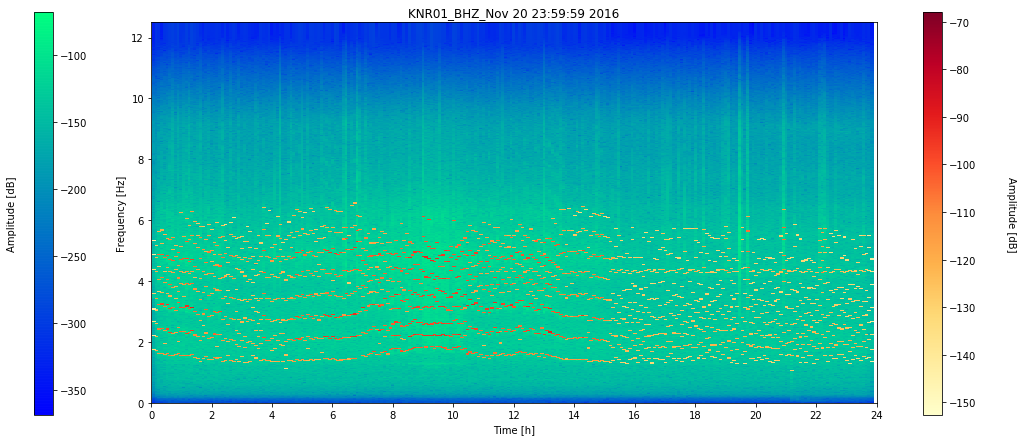

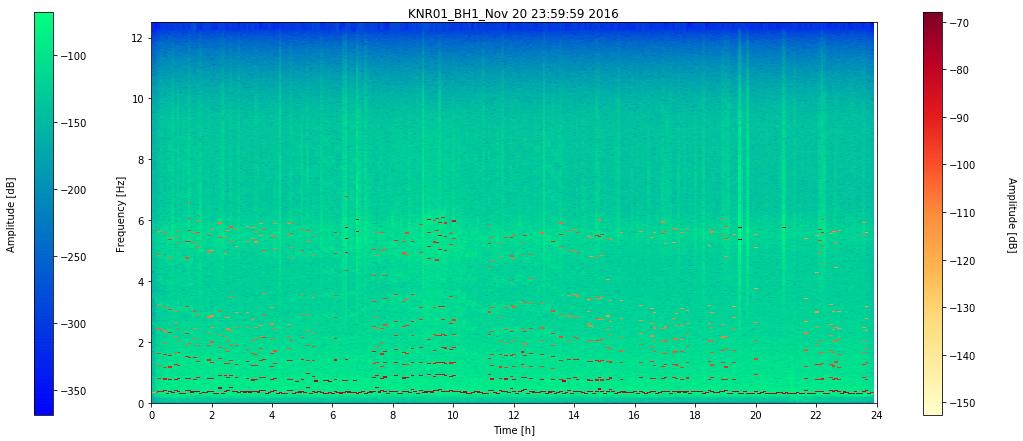

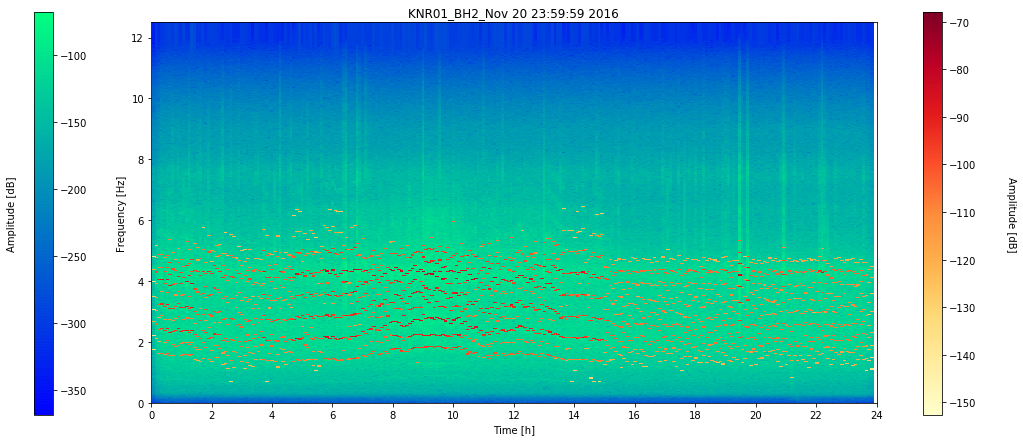

In [119]:
specgram_BHZ, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0)
specgram_BH1, freq, time = mlab.specgram(data_BH1, Fs=fs, NFFT=nfft, noverlap=0)
specgram_BH2, freq, time = mlab.specgram(data_BH2, Fs=fs, NFFT=nfft, noverlap=0)


#max_array_BHZ = np.zeros_like(specgram_BHZ)
#max_array_BH1 = np.zeros_like(specgram_BH1)
#max_array_BH2 = np.zeros_like(specgram_BH2)

threshold = np.amax(specgram_BHZ)*1e-25
freq_minimal_value = 3
distance = 120
maxima= 8
#all_win_average = np.mean(specgram.T)

max_array_Z = sorting_out_peacks(input_data=specgram_BHZ, freq_vec=freq, maxima=maxima, threshold = threshold, distance = distance, freq_minimal_value = freq_minimal_value)
max_array_1 = sorting_out_peacks(input_data=specgram_BH1, freq_vec=freq, maxima=maxima, threshold = threshold, distance = distance, freq_minimal_value = freq_minimal_value)
max_array_2 = sorting_out_peacks(input_data=specgram_BH2, freq_vec=freq, maxima=maxima, threshold = threshold, distance = distance, freq_minimal_value = freq_minimal_value)



vmin_amp =  10 * np.log10(np.min(np.hstack(([max_array_Z[max_array_Z != 0]], [max_array_1[max_array_1 != 0]],[max_array_2[max_array_2 != 0]]))))
vmax_amp =  10 * np.log10(np.max(np.array([max_array_Z,max_array_1,max_array_2])))
vmin_spec = 10 * np.log10(np.min(np.array([specgram_BHZ,specgram_BH1,specgram_BH2])))
vmax_spec = 10 * np.log10(np.max(np.array([specgram_BHZ,specgram_BH1,specgram_BH2])))

fig, ax = plt.subplots(figsize=(13,7))
specgramZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BHZ[1:,:]), alpha=.99, cmap='winter', vmin=vmin_spec, vmax=vmax_spec)
amp_valZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_Z),cmap='YlOrRd', vmin=vmin_amp,vmax=vmax_amp)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')

plt.xticks(np.linspace(0,24,13))
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BHZ_simu_filt[0].stats.station + '_' + st_BHZ_simu_filt[0].stats.channel + '_' + date)

cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgramZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_valZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]', rotation=270)
cb.ax.get_yaxis().labelpad = 40



fig, ax = plt.subplots(figsize=(13,7))
specgram1_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BH1[1:,:]), alpha=.99, cmap='winter',  vmin=vmin_spec, vmax=vmax_spec)
amp_val1_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_1),cmap='YlOrRd',vmin=vmin_amp,vmax=vmax_amp)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')

plt.xticks(np.linspace(0,24,13))
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BH1_simu_filt[0].stats.station + '_' + st_BH1_simu_filt[0].stats.channel + '_' + date)

cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgram1_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_val1_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]', rotation=270)
cb.ax.get_yaxis().labelpad = 40


fig, ax = plt.subplots(figsize=(13,7))
specgram2_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BH2[1:,:]), alpha=.99, cmap='winter',  vmin=vmin_spec, vmax=vmax_spec)
amp_val2_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_2),cmap='YlOrRd', vmin=vmin_amp,vmax=vmax_amp)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')

plt.xticks(np.linspace(0,24,13))
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BH2_simu_filt[0].stats.station + '_' + st_BH2_simu_filt[0].stats.channel + '_' + date)

cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgram2_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_val2_plot, cax = cbaxes) 
cb.ax.set_ylabel('Amplitude [dB]', rotation=270)
cb.ax.get_yaxis().labelpad = 40


#plt.xlim(2,6)
#plt.ylim(0,4)
#plt.grid(alpha=.1)


plt.show()

NameError: name 'specgram' is not defined

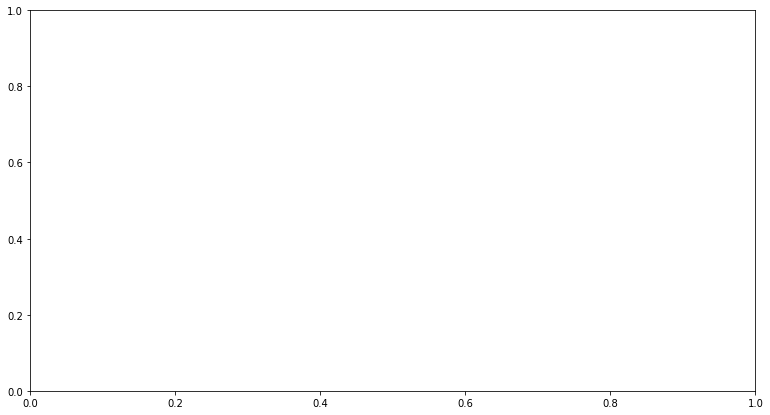

In [102]:
fig, ax = plt.subplots(figsize=(13,7))
specgram_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram[1:,:]), alpha=.6, cmap='winter')
amp_val_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array),cmap='YlOrRd')
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')
cbar = plt.colorbar(amp_val_plot)
cbar.set_clim(-160,-80)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('dB-scale', rotation=270)

plt.xticks(np.linspace(0,24,13))
#plt.xlim(2,6)
#plt.ylim(0,4)
#plt.grid(alpha=.1)

plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.show()

In [ ]:



fig, ax = plt.subplots(figsize=(13,7))
specgramZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram_BHZ[1:,:]), alpha=.8, cmap='winter', vmin=vmin_spec, vmax=vmax_spec)
amp_valZ_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array_Z),cmap='YlOrRd', vmin=vmin_amp,vmax=vmax_amp)
plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.title(st_BHZ_simu_filt[0].stats.station + '_' + st_BHZ_simu_filt[0].stats.channel + '_' + date)
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')
cbaxes = fig.add_axes([0, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(specgramZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('dB-scale')
cb.ax.get_yaxis().labelpad = -80
cbaxes = fig.add_axes([.95, 0.1, 0.02, 0.8]) 
cb = plt.colorbar(amp_valZ_plot, cax = cbaxes) 
cb.ax.set_ylabel('dB-scale', rotation=270)
cb.ax.get_yaxis().labelpad = 40
#

#cbar.set_clim(vmin,vmax)
#cbar.ax.get_yaxis().labelpad = 15
#cbar.ax.set_ylabel('dB-scale', rotation=270)

plt.xticks(np.linspace(0,24,13))
#plt.xlim(2,6)
#plt.ylim(0,4)
#plt.grid(alpha=.1)
plt.show()

In [ ]:
value_max, _, value_max_f = searchmaxima(maxima=10, data=specgram.T[175], distance=50, scale_vector=freq)
value_max1, _, value_max_f1 = searchmaxima(maxima=10, data=specgram.T[79], distance=50, scale_vector=freq)



#plt.plot(freq,specgram.T[17], label='eq')
#plt.plot(freq,specgram.T[33], label='eq')
plt.plot(freq,specgram.T[79], color='blue', label='local-eq')
plt.plot(value_max_f1, value_max1, 'o', color='blue')
plt.plot(freq,specgram.T[175], color='yellow', label='jumping-signal', alpha=.4)
plt.plot(value_max_f, value_max, 'o', color='yellow')
#plt.plot(freq,specgram.T[40], color='green', label='signal')
#plt.plot(value_max_f1, value_max1, 'o', color='green')
#plt.axhline(np.mean(specgram.T[117]), xmin=0, xmax=50, color='red', alpha=.5)
#plt.plot(freq, specgram.T[41], label='good pick')#, transform=rot + base)
#plt.plot(freq,specgram.T[41], label='noeq')
plt.axhline(np.mean(specgram.T[79]), xmin=0, xmax=50, color='blue', alpha=.5)
plt.axhline(np.mean(specgram.T),  xmin=0, xmax=50, color='red', alpha=.5)
plt.axhline(np.mean(specgram.T[175]),  xmin=0, xmax=50, color='yellow', alpha=.5)
#plt.ylim(0,.25*1e-10)
#plt.plot(specgram.T[60], label='150')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.pcolormesh(time, freq, 10 * np.log10(specgram[1:,:]))
#plt.pcolormesh( 10 * np.log10(max_array))
plt.grid()
plt.yticks(np.linspace(0,12,25))
#plt.xlim(10000,30000)
#plt.ylim(1,2)
plt.colorbar()
plt.show()

In [ ]:
500*12.5/4096

In [ ]:
testarray = np.zeros((np.shape(specgram)[1]))
for i in range(np.shape(specgram)[1]):
    testarray[i] = np.sum(specgram.T[i])
    
print(np.mean(testarray))

In [ ]:
plt.plot(testarray)
plt.plot(0,np.mean(testarray), 'o')
plt.show()

In [ ]:
amp_value, no_samp, freqs= searchmaxima(maxima=3, data=specgram.T[100], scale_vector=freq)

In [ ]:
plt.plot(63, no_samp[0], 'o')
plt.show()
print(np.shape(specgram))

In [ ]:
plt.figure(figsize=(12,8))
for i in range(63,64):
    value_max, _,value_max_f = searchmaxima(maxima=10, data=specgram.T[i], scale_vector=freq)
    plt.plot(freq,specgram.T[i], alpha=.3)
    plt.scatter(value_max_f, value_max, s=value_max*1e12, color='tomato')
    plt.grid(alpha=.3)
    plt.xlim(0,8)
    plt.xticks(np.linspace(0,8,17))
    plt.xlabel('Frequency [Hz]')
    print(i)
plt.show()

In [ ]:
print(value_max*1e10)

In [ ]:
plt.figure(figsize=(12,8))
for i in range(np.shape(specgram.T)[0]):
    value_max, _,value_max_f = searchmaxima(maxima=10, data=specgram.T[i], scale_vector=freq)
    plt.plot(freq,specgram.T[i], alpha=.1)
    plt.scatter(value_max_f, value_max, s=value_max*1e12, color='tomato')
    plt.ylim(0,1.5e-9)
    plt.xlim(0,8)
    plt.xticks(np.linspace(0,8,17))
    plt.xlabel('Frequency [Hz]')
    
    if i%5 == 0:
        plt.savefig('../../Plots/test1/'+ str(i))
        plt.clf()
#plt.show()

In [ ]:
plt.plot(specgram[948])
plt.plot((value_max_f), (value_max), 'o')
#plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



In [ ]:
test = np.linspace(20,30,11)

In [ ]:
print(test.mean())

In [ ]:
24*3600

In [ ]:
a = np.linspace(0,9,10)
b = np.linspace(0,2,3)
c = np.ones((len(a), len(b)))

In [ ]:
for i in range(len(a)):
    for j in range(len(b)):
        c[i,j] *= np.random.rand()

In [ ]:
print(c)

In [ ]:
plt.pcolormesh(c)
plt.colorbar()
plt.show()

In [ ]:
print(c.T[0])

In [ ]:
20000*264/86400

In [ ]:
print(len(freq))